In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Загрузка данных из CSV файла
df = pd.read_csv('/home/jovyan/work/task3/Steel_industry_data.csv')

print("\nИнформация о данных:")
df.info()

print("\nОсновные статистические характеристики:")
print(df.describe(include='all'))

print(df.isnull().sum())
print((df == 'None').sum())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object

In [7]:
# Кодирование категориальных переменных
label_encoder = LabelEncoder()
df['WeekStatus'] = label_encoder.fit_transform(df['WeekStatus'])
df['Day_of_week'] = label_encoder.fit_transform(df['Day_of_week'])
df['Load_Type'] = label_encoder.fit_transform(df['Load_Type'])

# Вывод информации о DataFrame после преобразований
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  int64  
 9   Day_of_week                           35040 non-null  int64  
 10  Load_Type                             35040 non-null  int64  
dtypes: float64(6), 

In [8]:
# Предварительная обработка данных
# Преобразование даты в datetime и установка как индекса
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df.set_index('date', inplace=True)

# Добавление синусоидальных и косинусоидальных признаков для часов
df['hour_sin'] = np.sin(df.index.hour * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df.index.hour * (2. * np.pi / 24))

# Добавление синусоидальных и косинусоидальных признаков для месяцев
df['month_sin'] = np.sin((df.index.month-1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((df.index.month-1) * (2. * np.pi / 12))

df.reset_index(drop=True, inplace=True)
df = df.astype(float)
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,hour_sin,hour_cos,month_sin,month_cos
0,3.17,2.95,0.0,0.0,73.21,100.0,900.0,0.0,1.0,0.0,0.000000,1.000000,0.0,1.0
1,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,0.0,1.0,0.0,0.000000,1.000000,0.0,1.0
2,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,0.0,1.0,0.0,0.000000,1.000000,0.0,1.0
3,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,0.0,1.0,0.0,0.258819,0.965926,0.0,1.0
4,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,0.0,1.0,0.0,0.258819,0.965926,0.0,1.0


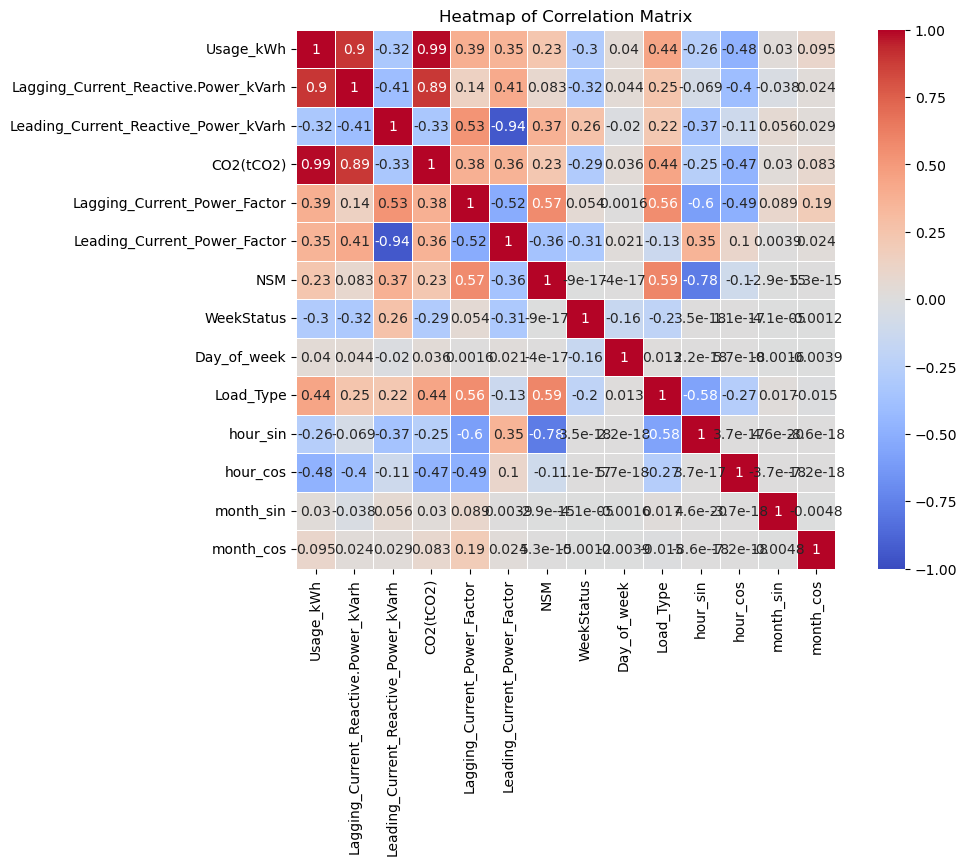

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()

# Plotting the heatmap for the correlation matrix
plt.figure(figsize=(11, 7))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()


In [ ]:
# Analysys results Исследуем Usage_kWh
"""

Выводы:
- Высокая корреляция между Usage_kWh и CO2(tCO2):
    С увеличением потребления электроэнергии (kWh), увеличивается производство углекислого газа. 
    Это важно для моделей, прогнозирующих энергопотребление или выбросы CO2

- Сильная корреляция между Leading_Current_Reactive_Power_kVarh и Leading_Current_Power_Factor: 
    Отрицательная корреляция указывает на то, что с увеличением реактивной мощности ухудшается коэффициент мощности. 
    Это важно для задач, связанных с управлением энергоэффективностью и качеством электроэнергии.

-Корреляция между временными признаками (hour_sin, hour_cos, month_sin, month_cos) и другими переменными:
    Низкая корреляция временных признаков с другими переменными
    временные аспекты (время суток, месяц) не оказывают сильного прямого влияния на другие измерения

Стоит учесть:
- Мультиколлениарность - возможность удаления одной из коррелирующих переменных или использования методов уменьшения размерности,
    таких как PCA (метод главных компонент).

- Фокус на значимых корреляциях: Возможность включения переменных имеющих значительные корреляции с целевой переменной

"""



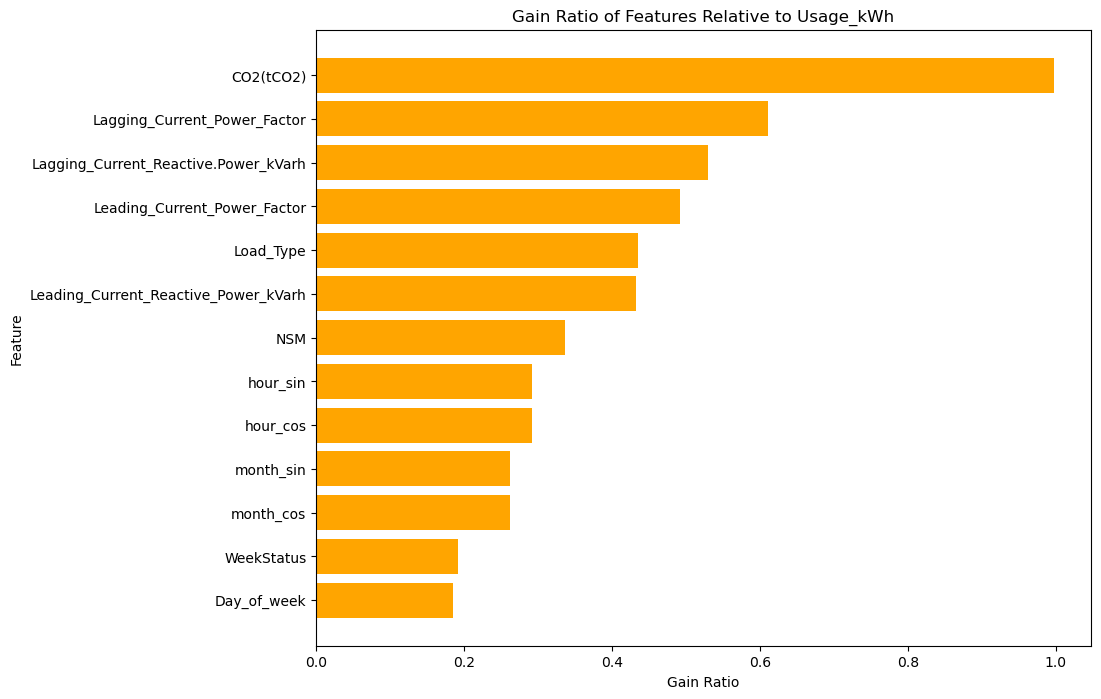

In [10]:
from math import log2

def calculate_entropy(series):
    counts = series.value_counts()
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities + np.finfo(float).eps))
    return entropy

def calculate_conditional_entropy(df, attribute, target):
    total_rows = len(df)
    probabilities = df[attribute].value_counts() / total_rows
    conditional_entropy = 0.0
    for value, prob in probabilities.items():
        subset_entropy = calculate_entropy(df[df[attribute] == value][target])
        conditional_entropy += prob * subset_entropy
    return conditional_entropy

def calculate_information_gain(df, attribute, target):
    total_entropy = calculate_entropy(df[target])
    conditional_entropy = calculate_conditional_entropy(df, attribute, target)
    return total_entropy - conditional_entropy

def calculate_gain_ratio(df, attribute, target):
    information_gain = calculate_information_gain(df, attribute, target)
    split_info = calculate_entropy(df[attribute])
    return information_gain / split_info if split_info != 0 else 0

feature_cols = [col for col in df.columns if col != 'Usage_kWh']
gain_ratios = {col: calculate_gain_ratio(df, col, 'Usage_kWh') for col in feature_cols}

sorted_gain_ratios = sorted(gain_ratios.items(), key=lambda item: item[1], reverse=True)

plt.figure(figsize=(10, 8))
plt.barh([item[0] for item in sorted_gain_ratios], [item[1] for item in sorted_gain_ratios], color='orange')
plt.xlabel('Gain Ratio')
plt.ylabel('Feature')
plt.title('Gain Ratio of Features Relative to Usage_kWh')
plt.gca().invert_yaxis()
plt.show()


In [11]:
df = df.drop(['Day_of_week', 'WeekStatus'], axis=1) # less 0.2
#df = df.drop(['hour_sin', 'hour_cos', 'month_sin', 'month_cos'], axis=1) # less 0.3

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  float64
 7   Load_Type                             35040 non-null  float64
 8   hour_sin                              35040 non-null  float64
 9   hour_cos                              35040 non-null  float64
 10  month_sin                             35040 non-null  float64
 11  month_cos      

Epoch: 0, Train Loss: 0.65050776, Test Loss: 0.20959440
Epoch: 10, Train Loss: 0.03838593, Test Loss: 0.02699164
Epoch: 20, Train Loss: 0.02656191, Test Loss: 0.01832250
Epoch: 30, Train Loss: 0.02211147, Test Loss: 0.01455992
Epoch: 40, Train Loss: 0.01980441, Test Loss: 0.01306439
Epoch: 50, Train Loss: 0.01823424, Test Loss: 0.01196579
Epoch: 60, Train Loss: 0.01700134, Test Loss: 0.01111872
Epoch: 70, Train Loss: 0.01596524, Test Loss: 0.01053706
Epoch: 80, Train Loss: 0.01507801, Test Loss: 0.01009148
Epoch: 90, Train Loss: 0.01430640, Test Loss: 0.00973321
Epoch: 100, Train Loss: 0.01362667, Test Loss: 0.00942524
Epoch: 110, Train Loss: 0.01302265, Test Loss: 0.00914342


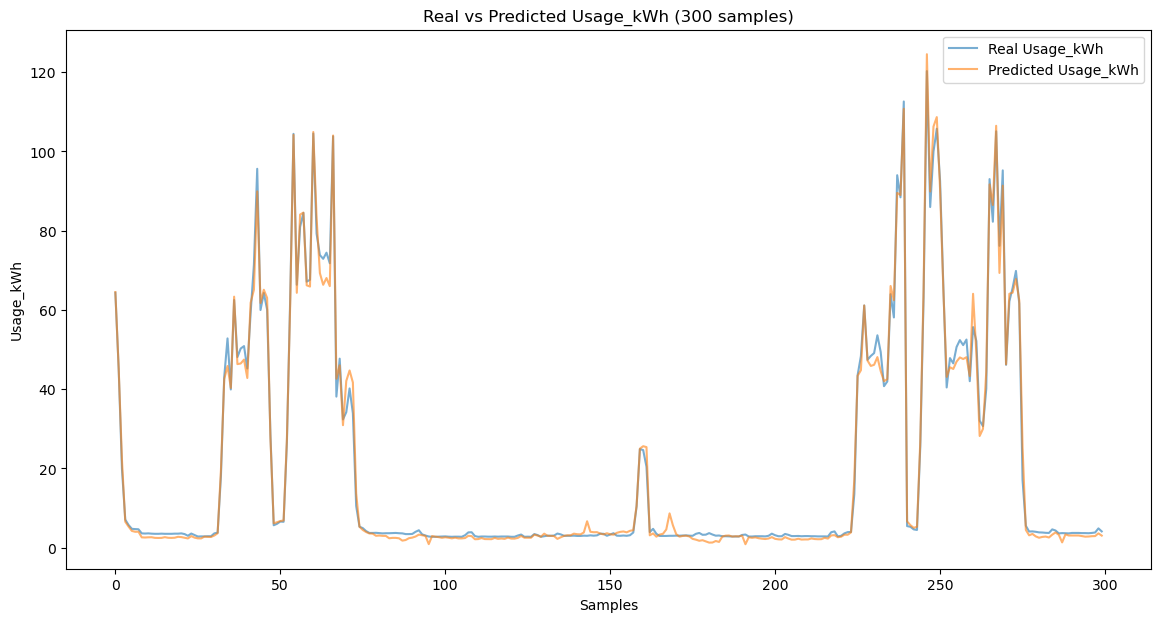

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def initialize_weights(size, scale=1.0):
    return np.random.uniform(-1, 1, size) / np.sqrt(scale)

class ImprovedRNN:
    def __init__(self, input_size, hidden_size, output_size):
        scale = hidden_size
        # матрица весов входного слоя
        self.U = initialize_weights((input_size, hidden_size), scale)
        # матрица рекуррентных весов (связь со предыдущим состоянием скрытого слоя)
        self.W = initialize_weights((hidden_size, hidden_size), scale)
        # матрица весов для выходного слоя
        self.V = initialize_weights((hidden_size, output_size), scale)
        # смещение для скрытого слоя
        self.bh = np.zeros((1, hidden_size))
        # смещение выходного слоя
        self.by = np.zeros((1, output_size))
        # предыдущее состояние скрытого слоя
        self.hidden_state = np.zeros((1, hidden_size))

    def step_forward(self, input_vector):
        # обновление скрытого состояния
        self.hidden_state = sigmoid(np.dot(input_vector, self.U) + np.dot(self.hidden_state, self.W) + self.bh)
        # Вычисление выхода
        output = np.dot(self.hidden_state, self.V) + self.by
        return output

    def step_backward(self, input_vector, output, target, learning_rate):
        # вычисление ошибки на выходном слое
        output_error = 2 * (output - target) / target.shape[0]
        
        # вычисление градиентов для весов выходного слоя (V)
        V_grad = np.dot(self.hidden_state.T, output_error)

        # вычисление градиентов для смещения выходного слоя (V)
        by_grad = np.sum(output_error, axis=0, keepdims=True)

        # вычисление ошибки на скрытом слое
        hidden_error = np.dot(output_error, self.V.T) * sigmoid_derivative(self.hidden_state)

        # вычисление градиентов для весов входного слоя
        U_grad = np.dot(input_vector.T, hidden_error)

        # вычисление градиентов для рекуррентных весов
        W_grad = np.dot(self.hidden_state.T, hidden_error)

        # вычисление градиентов для смещения скрытого слоя
        bh_grad = np.sum(hidden_error, axis=0, keepdims=True)

        # обновление весов и смещений
        self.V -= learning_rate * V_grad
        self.by -= learning_rate * by_grad
        self.U -= learning_rate * U_grad
        self.W -= learning_rate * W_grad
        self.bh -= learning_rate * bh_grad

    def train(self, X_train, y_train, X_test=None, y_test=None, epochs=100, learning_rate=0.001, batch_size=32):
        for epoch in range(epochs):
            train_losses = [] # Список для хранения потерь на тренировочных данных.
            for i in range(0, len(X_train), batch_size):
                batch_X, batch_y = X_train[i:i+batch_size], y_train[i:i+batch_size]
                outputs, states = [], [] # Список выходов и скрытых состояний для всех примеров в батче.

                # Прямое распространение
                for x in batch_X:
                    # Вычисляет выходной вектор для каждого входного вектора x в батче
                    out = self.step_forward(x.reshape(1, -1))
                    outputs.append(out)
                    states.append(self.hidden_state)

                outputs = np.vstack(outputs)
                states = np.vstack(states)
                batch_y = batch_y.reshape(-1, 1)

                # Обратное распространение для каждого примера в батче
                for j in range(batch_X.shape[0]):
                    self.step_backward(batch_X[j].reshape(1, -1), outputs[j].reshape(1, -1), batch_y[j].reshape(1, -1), learning_rate)

                batch_loss = np.mean((outputs - batch_y) ** 2)
                train_losses.append(batch_loss)

            train_loss = np.mean(train_losses)
            
            if X_test is not None and y_test is not None:
                test_losses = []
                for i in range(X_test.shape[0]):
                    input_vector = X_test[i].reshape(1, -1)
                    target_vector = y_test[i].reshape(1, -1)
                    output = self.step_forward(input_vector)
                    loss = np.mean((output - target_vector) ** 2)
                    test_losses.append(loss)
                test_loss = np.mean(test_losses)
                if epoch % 10 == 0:
                    print(f"Epoch: {epoch}, Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}")
            else:
                if epoch % 10 == 0:
                    print(f"Epoch: {epoch}, Train Loss: {train_loss:.8f}")

X = df.drop('Usage_kWh', axis=1).values
y = df['Usage_kWh'].values.reshape(-1, 1)

# Нормализация признаков и целевой переменной
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

# Определение размеров входа, скрытого слоя и выхода
input_size = X_train.shape[1]
hidden_size = 10  
output_size = 1

rnn = ImprovedRNN(input_size, hidden_size, output_size)
rnn.train(X_train, y_train, X_test, y_test, epochs=120, learning_rate=0.0001, batch_size=16)

# Предсказания на тестовом наборе данных
predictions = []
for x in X_test:
    pred = rnn.step_forward(x.reshape(1, -1))
    predictions.append(pred)

predictions = np.array(predictions).reshape(-1, 1)

# Обратное масштабирование предсказанных значений
y_test_inverse = scaler_y.inverse_transform(y_test)
predictions_inverse = scaler_y.inverse_transform(predictions)

# Построение графика для промежутка из 300 значений
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse[:300], label='Real Usage_kWh', alpha=0.6)
plt.plot(predictions_inverse[:300], label='Predicted Usage_kWh', alpha=0.6)
plt.xlabel('Samples')
plt.ylabel('Usage_kWh')
plt.title('Real vs Predicted Usage_kWh (300 samples)')
plt.legend()
plt.show()


Precision: 0.7058567385151318
Recall: 0.9281419982822788
F1 Score: 0.8018797922334899
AUC: 0.9345688328496049


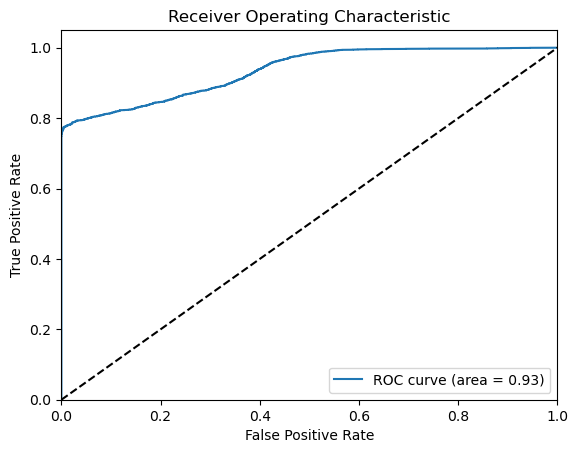

In [15]:
# Добавляем расчет метрик
def calculate_precision_recall_f1(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def calculate_auc_roc(y_true, y_scores):
    # Сортируем значения по убыванию
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]
    
    tpr_list = []
    fpr_list = []
    tp = 0
    fp = 0
    tn = np.sum(y_true == 0)
    fn = np.sum(y_true == 1)

    for i in range(len(y_scores)):
        if y_true[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc = np.trapz(tpr_list, fpr_list)
    return auc, fpr_list, tpr_list

# Преобразование в бинарные метки на основе медианы
threshold = np.median(y_test_inverse)
y_test_binary = (y_test_inverse > threshold).astype(int)
predictions_binary = (predictions_inverse > threshold).astype(int)

# Вычисление метрик
precision, recall, f1 = calculate_precision_recall_f1(y_test_binary, predictions_binary)
auc, fpr, tpr = calculate_auc_roc(y_test_binary, predictions_inverse.ravel())

# Вывод метрик
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC: {auc}')

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()